<div style="text-align: center;">
    <img src="https://user-images.githubusercontent.com/86345471/221379942-51f24819-1f76-4289-8dee-06ea69f730f6.png" alt=Main "KPI />
</d></br>
Pr №1 — Data Analysis

Дані: Global Population Stats 2024 (Kaggle)

Мета: аналіз, візуалізація, нормалізація та класифікація даних за допомогою kNN, Decision Tree, SVM, Random Forest, AdaBoost.

In [1]:
# === 1. Завантаження даних ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Завантаження CSV з Kaggle
df = pd.read_csv('global_population_stats_2024.csv')

print('Розмір датасету:', df.shape)
print('Назви колонок:', df.columns.tolist())
display(df.head())

Розмір датасету: (192, 8)
Назви колонок: ['Country', 'Population Aged 0 to 14 (%)', 'Population Aged 60 and Over (%)', 'Population density', 'Population(in millions)', 'Female Population(in millions)', 'Male Population(in millions)', 'Sex ratio (males per 100 females)']


,Country,Population Aged 0 to 14 (%),Population Aged 60 and Over (%),Population density,Population(in millions),Female Population(in millions),Male Population(in millions),Sex ratio (males per 100 females)
0,Afghanistan,42.9,3.9,65.7,42.65,21.12,21.53,102.0
1,Albania,16.8,23.5,101.9,2.79,1.41,1.38,97.8
2,Algeria,30.3,10.0,19.7,46.81,22.94,23.87,104.1
3,Andorra,11.9,23.2,174.3,0.08,0.04,0.04,104.6
4,Angola,44.4,4.6,30.4,37.89,19.14,18.75,98.0


In [2]:
# === 2. Опрацювання пропусків ===
print('Пропуски по колонках:')
print(df.isnull().sum())

# Заповнюємо числові середніми, текстові — модою
df = df.fillna(df.mean(numeric_only=True))
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print('\nПісля обробки залишилось пропусків:', df.isnull().sum().sum())

Пропуски по колонках:
Country                              0
Population Aged 0 to 14 (%)          0
Population Aged 60 and Over (%)      0
Population density                   0
Population(in millions)              0
Female Population(in millions)       0
Male Population(in millions)         0
Sex ratio (males per 100 females)    0
dtype: int64

Після обробки залишилось пропусків: 0


In [3]:
# === 3. Створення цільової змінної ===
# Шукаємо колонку, де є слово Population
target_feature = None
for col in df.columns:
    if 'Population(' in col:
        target_feature = col
        break

if target_feature is None:
    raise ValueError('❌ Не знайдено колонку Population!')

print('✅ Використовується колонка:', target_feature)

# Поділяємо на 3 категорії: low / medium / high
bins = [-1, df[target_feature].quantile(0.33), df[target_feature].quantile(0.66), df[target_feature].max()]
labels = ['low', 'medium', 'high']
df['population_class'] = pd.cut(df[target_feature], bins=bins, labels=labels)

print(df[[target_feature, 'population_class']].head())

✅ Використовується колонка: Population(in millions)
   Population(in millions) population_class
0                    42.65             high
1                     2.79              low
2                    46.81             high
3                     0.08              low
4                    37.89             high


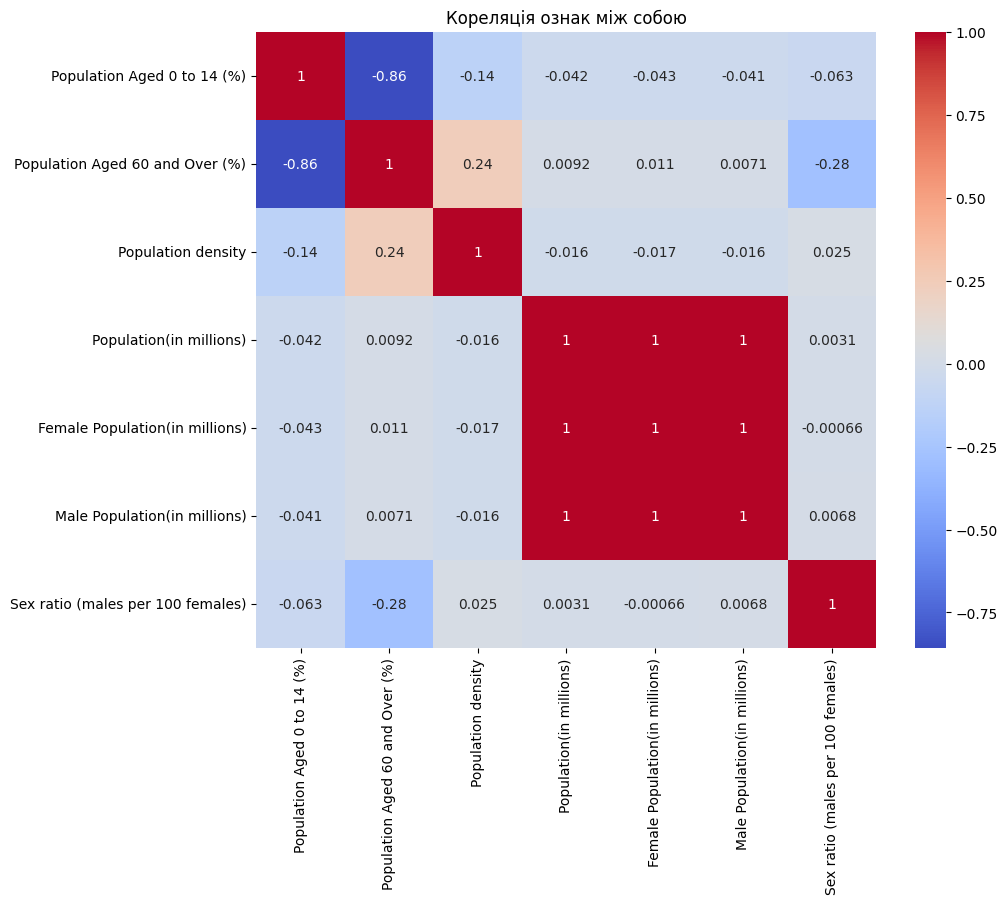

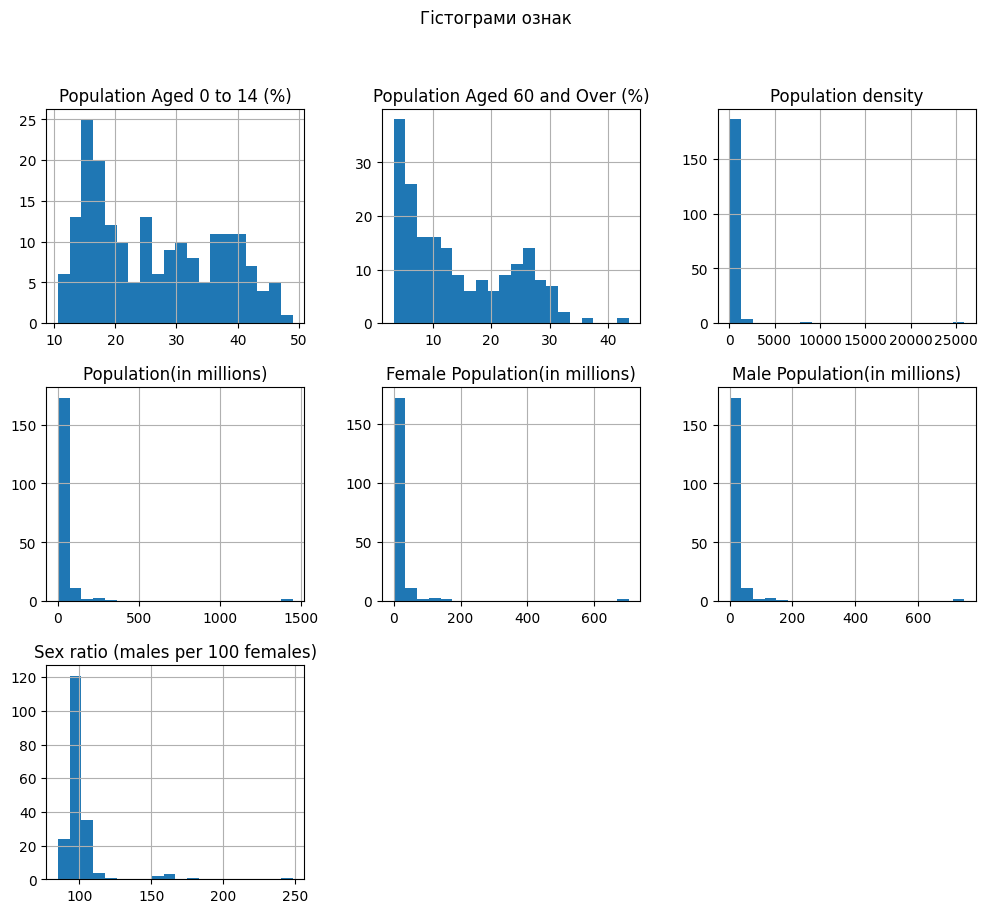

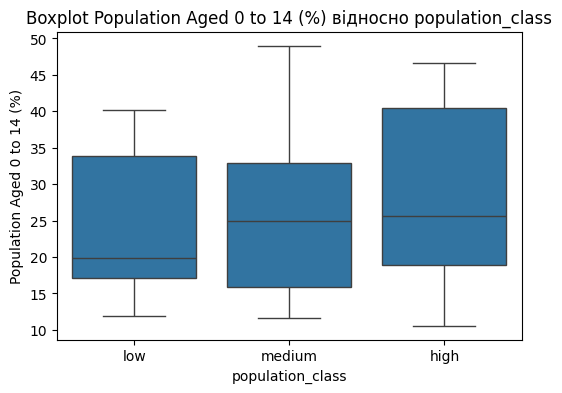

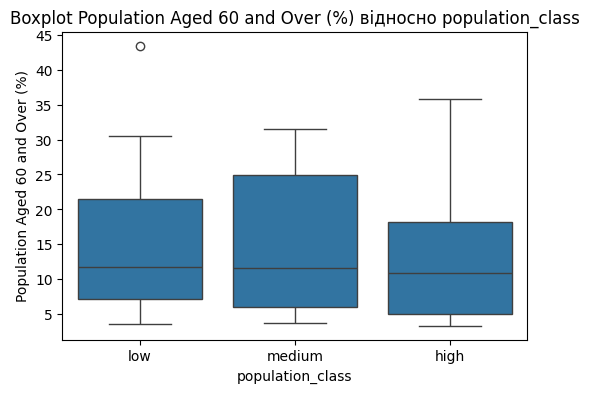

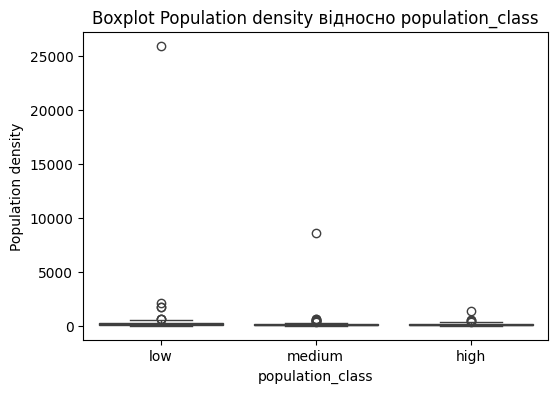

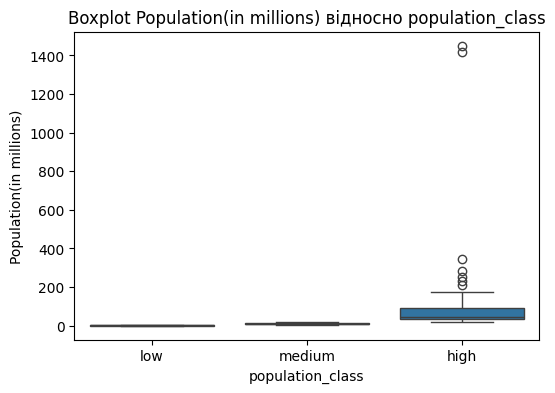

In [4]:
# === 4. Візуалізація ===
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Кореляція ознак між собою')
plt.show()

df.hist(figsize=(12,10), bins=20)
plt.suptitle('Гістограми ознак')
plt.show()

num_cols = df.select_dtypes(include=['float64','int64']).columns[:4]
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df['population_class'], y=df[col])
    plt.title(f'Boxplot {col} відносно population_class')
    plt.show()

In [5]:
# === 5. Нормалізація даних ===
drop_cols = ['population_class', 'Country']
X = df.drop(columns=drop_cols)
y = df['population_class']

le = LabelEncoder()
y_enc = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.3, random_state=42)

print('Розмір тренувальної вибірки:', X_train.shape)
print('Розмір тестової вибірки:', X_test.shape)

Розмір тренувальної вибірки: (134, 7)
Розмір тестової вибірки: (58, 7)


In [6]:
# === 6. Навчання моделей ===
results = {}

# kNN
best_k, best_score = 1, 0
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    if score > best_score:
        best_k, best_score = k, score
results['kNN'] = (best_k, best_score)
print('kNN: найкращий k =', best_k, ', accuracy =', round(best_score,3))

# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
results['DecisionTree'] = tree.score(X_test, y_test)
print('DecisionTree accuracy =', round(results['DecisionTree'],3))

# SVM (GridSearch)
param_grid = {'C':[0.1,1,10,100], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid.fit(X_train, y_train)
results['SVM'] = grid.best_score_
print('SVM best params:', grid.best_params_, ', accuracy =', round(results['SVM'],3))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['RandomForest'] = rf.score(X_test, y_test)
print('RandomForest accuracy =', round(results['RandomForest'],3))

# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
results['AdaBoost'] = ada.score(X_test, y_test)
print('AdaBoost accuracy =', round(results['AdaBoost'],3))

kNN: найкращий k = 3 , accuracy = 0.724
DecisionTree accuracy = 1.0
SVM best params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} , accuracy = 0.866
RandomForest accuracy = 1.0
AdaBoost accuracy = 1.0



=== Результати ===
kNN : (3, 0.7241379310344828)
DecisionTree : 1.0
SVM : 0.8655270655270655
RandomForest : 1.0
AdaBoost : 1.0

Найкраща модель: DecisionTree

=== Classification Report ===
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        16
         low       1.00      1.00      1.00        20
      medium       1.00      1.00      1.00        22

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


=== Confusion Matrix ===


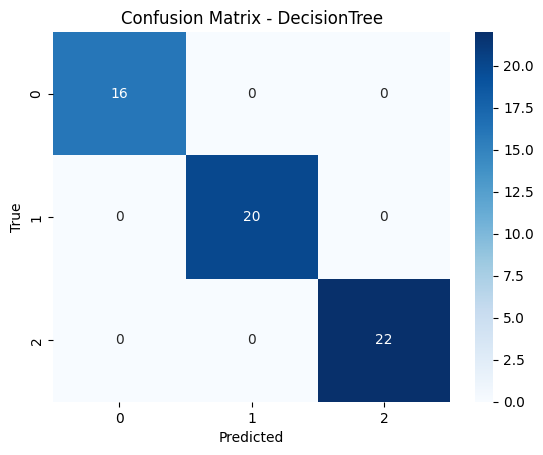

In [7]:
# === 7. Підсумки ===
print('\n=== Результати ===')
for model, score in results.items():
    print(model, ':', score)

best_model_name = max(results, key=lambda k: results[k][1] if isinstance(results[k], tuple) else results[k])
print('\nНайкраща модель:', best_model_name)

if best_model_name == 'kNN':
    model = KNeighborsClassifier(n_neighbors=results['kNN'][0])
elif best_model_name == 'SVM':
    model = grid.best_estimator_
elif best_model_name == 'DecisionTree':
    model = tree
elif best_model_name == 'RandomForest':
    model = rf
else:
    model = ada

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('\n=== Classification Report ===')
print(classification_report(y_test, y_pred, target_names=le.classes_))

print('\n=== Confusion Matrix ===')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()